<a href="https://colab.research.google.com/github/coryncates/Project-Core/blob/main/Adult_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adult Income Dataset


  - Author:  Cory N. Cates
  - Date: 7/20/23

## Dataset info:

1. Source of data:  Kaggle (https://www.kaggle.com/datasets/wenruliu/adult-income-dataset  &. https://www.kaggle.com/datasets/fedesoriano/cirrhosis-prediction-dataset)

2. Brief description of data:  

- INCOME:  This data appears to be demographic and employment information about individuals. The dataset includes the following features:
   
        ### Adult Income
  - age: Age of the individual.
  - workclass: Type of working class (e.g., Private, Local-gov).
  - fnlwgt: Final weight, this attribute is used by the Census, it's a sort of 'number of people the census believes the entry represents'.
  - education: The highest level of education achieved by the individual.
  - educational-num: The highest level of education in numerical form.
  - marital-status: Marital status of the individual.
  - occupation: The individual's occupation.
  - relationship: The individual's relationship status.
  - race: Race of the individual.
  - gender: Gender of the individual.
  - capital-gain: Capital gains for the individual.
  - capital-loss: Capital loss for the individual.
  - hours-per-week: Hours worked per week.
  - native-country: Native country of the individual.
  - income: Whether the person makes more than 50K a year.

    

3. What is the target?

  - income (binary object)



4. What does one row represent? (A person? A business? An event? A product?)

  - an individual with their corresponding demographic and employment information.


5. Is this a classification or regression problem?

  - classification



6. How many features does the data have?

  - 14 features; so 13 predictors (15 columns)



7. How many rows are in the dataset?

  - 48842



8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

  - Missing values
  - Proper encoding
  - Imbalanced Data
  - Dropping features
  - Outliers
  - Data Normalization

# Necessary EDA and Packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingRegressor # NEW


from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay   # New!
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay



In [4]:
# Updating the function to change target
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax



In [5]:
def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")




  # Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax



In [6]:
# Updating function
def plot_categorical_vs_target(df, x, y = 'income', figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax


In [7]:
# Updating the function to change target
def plot_numeric_vs_target(df, x, y = 'income', figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax



In [8]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



In [9]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



In [10]:
# We will be reproducing thie plot many times, so let's turn it into a short-term function
def plot_cv_results(gs, param_name='param_logisticregression__C', logx = True):
    # Making a dataframe with cv_results_
  cv_results = pd.DataFrame(gs.cv_results_)
  # Save the train/test scores with values for C
  scores = cv_results[[param_name,'mean_train_score','mean_test_score']]
  scores = scores.set_index(param_name)
  ## Plot the training vs test scores vs. C
  ax = scores.plot(y=['mean_test_score','mean_train_score'],
              style='o-',logx=logx)
  ax.set(ylabel=gs.scoring)
  print(scores['mean_test_score'])
  return ax



# Beginning of Exploratory/Explanatory Analysis

In [11]:
fpath = "/content/drive/MyDrive/CodingDojo/02-MachineLearning/Week07/Data/adult.csv"
df = pd.read_csv(fpath)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [12]:
# Check summary statistics
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


##**Clean Data**

-  There is a column that we can do without:

  - fnlwgt - census data
  - Native Country

####**Disclaimer**
    - I would normally hesitate to remove unnecessary columns/duplicates, but because this is attached to the assignment, I will follow instructions.  The KNN imputation that we will eventually be using will take care of most of this for us.


In [13]:
# Check for how many unique values are in each column.
df.nunique()

age                   74
workclass              9
fnlwgt             28523
education             16
educational-num       16
marital-status         7
occupation            15
relationship           6
race                   5
gender                 2
capital-gain         123
capital-loss          99
hours-per-week        96
native-country        42
income                 2
dtype: int64

In [14]:
# What is the percentage of unique values in each column
df.nunique() / len(df) * 100

age                 0.151509
workclass           0.018427
fnlwgt             58.398509
education           0.032759
educational-num     0.032759
marital-status      0.014332
occupation          0.030711
relationship        0.012285
race                0.010237
gender              0.004095
capital-gain        0.251832
capital-loss        0.202694
hours-per-week      0.196552
native-country      0.085992
income              0.004095
dtype: float64

In [15]:
# Checking nuniuqe categories
df.select_dtypes('object').nunique()

workclass          9
education         16
marital-status     7
occupation        15
relationship       6
race               5
gender             2
native-country    42
income             2
dtype: int64

In [16]:
# Checking for Null Values # No Nulls
df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [17]:
# Identify string columns
string_cols = df.select_dtypes("object").columns
string_cols



Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country', 'income'],
      dtype='object')

In [18]:
# Obtain the value counts for all string columns
for col in string_cols:
  print(f"Value Counts for {col}")
  print(df[col].value_counts())
  # Increasing readability by adding an empty line
  print('\n')

Value Counts for workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


Value Counts for education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64


Value Counts for marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: marital-status, dtype: int64


Value Coun

# Visualizations

### Univariate examples

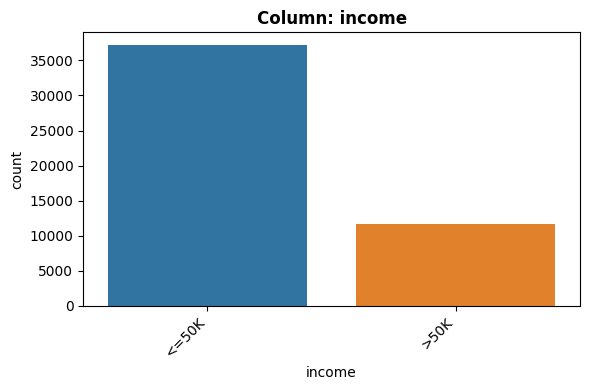

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '<=50K' occurs 37155 times (76.07%)
- Not constant or quasi-constant.


In [19]:
explore_categorical(df,'income');

In [20]:
# Convert Target to Numeric to exlore the numeric function.  # Exploratory
income_int = df['income'].replace({'<=50K':0, '>50K':1})
income_int.head()


0    0
1    0
2    1
3    1
4    0
Name: income, dtype: int64

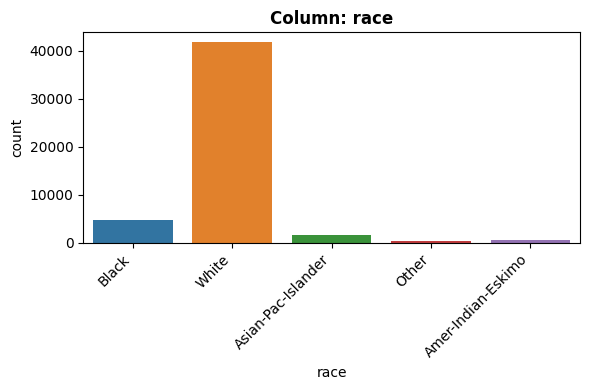

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: 'White' occurs 41762 times (85.5%)
- Not constant or quasi-constant.


In [21]:
explore_categorical(df,'race');

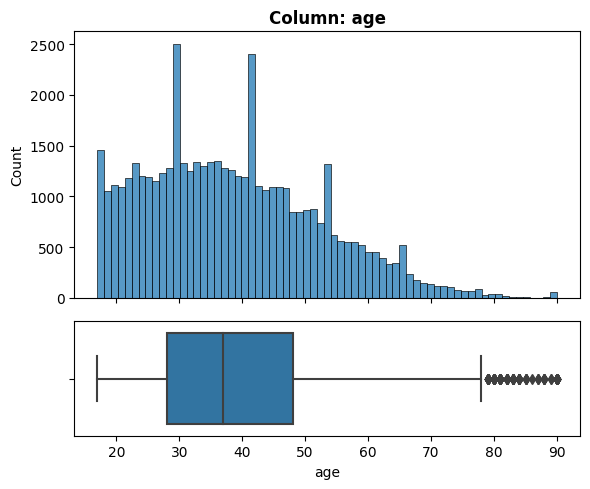

- NaN's Found: 0 (0.0%)


In [22]:
explore_numeric(df,'age');

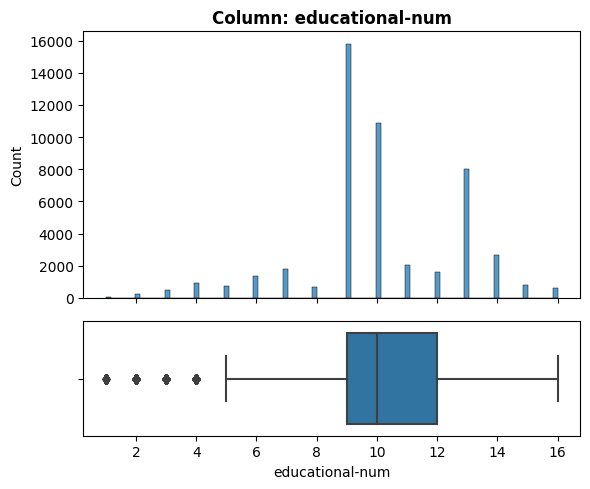

- NaN's Found: 0 (0.0%)


In [23]:
explore_numeric(df,'educational-num');

### Multivariate Evaluation

In [24]:
# Get correlations
corr = df.corr(numeric_only = True)
corr.round(2)



,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
age,1.00,-0.08,0.03,0.08,0.06,0.07
fnlwgt,-0.08,1.00,-0.04,-0.00,-0.00,-0.01
educational-num,0.03,-0.04,1.00,0.13,0.08,0.14
capital-gain,0.08,-0.00,0.13,1.00,-0.03,0.08
capital-loss,0.06,-0.00,0.08,-0.03,1.00,0.05
hours-per-week,0.07,-0.01,0.14,0.08,0.05,1.00


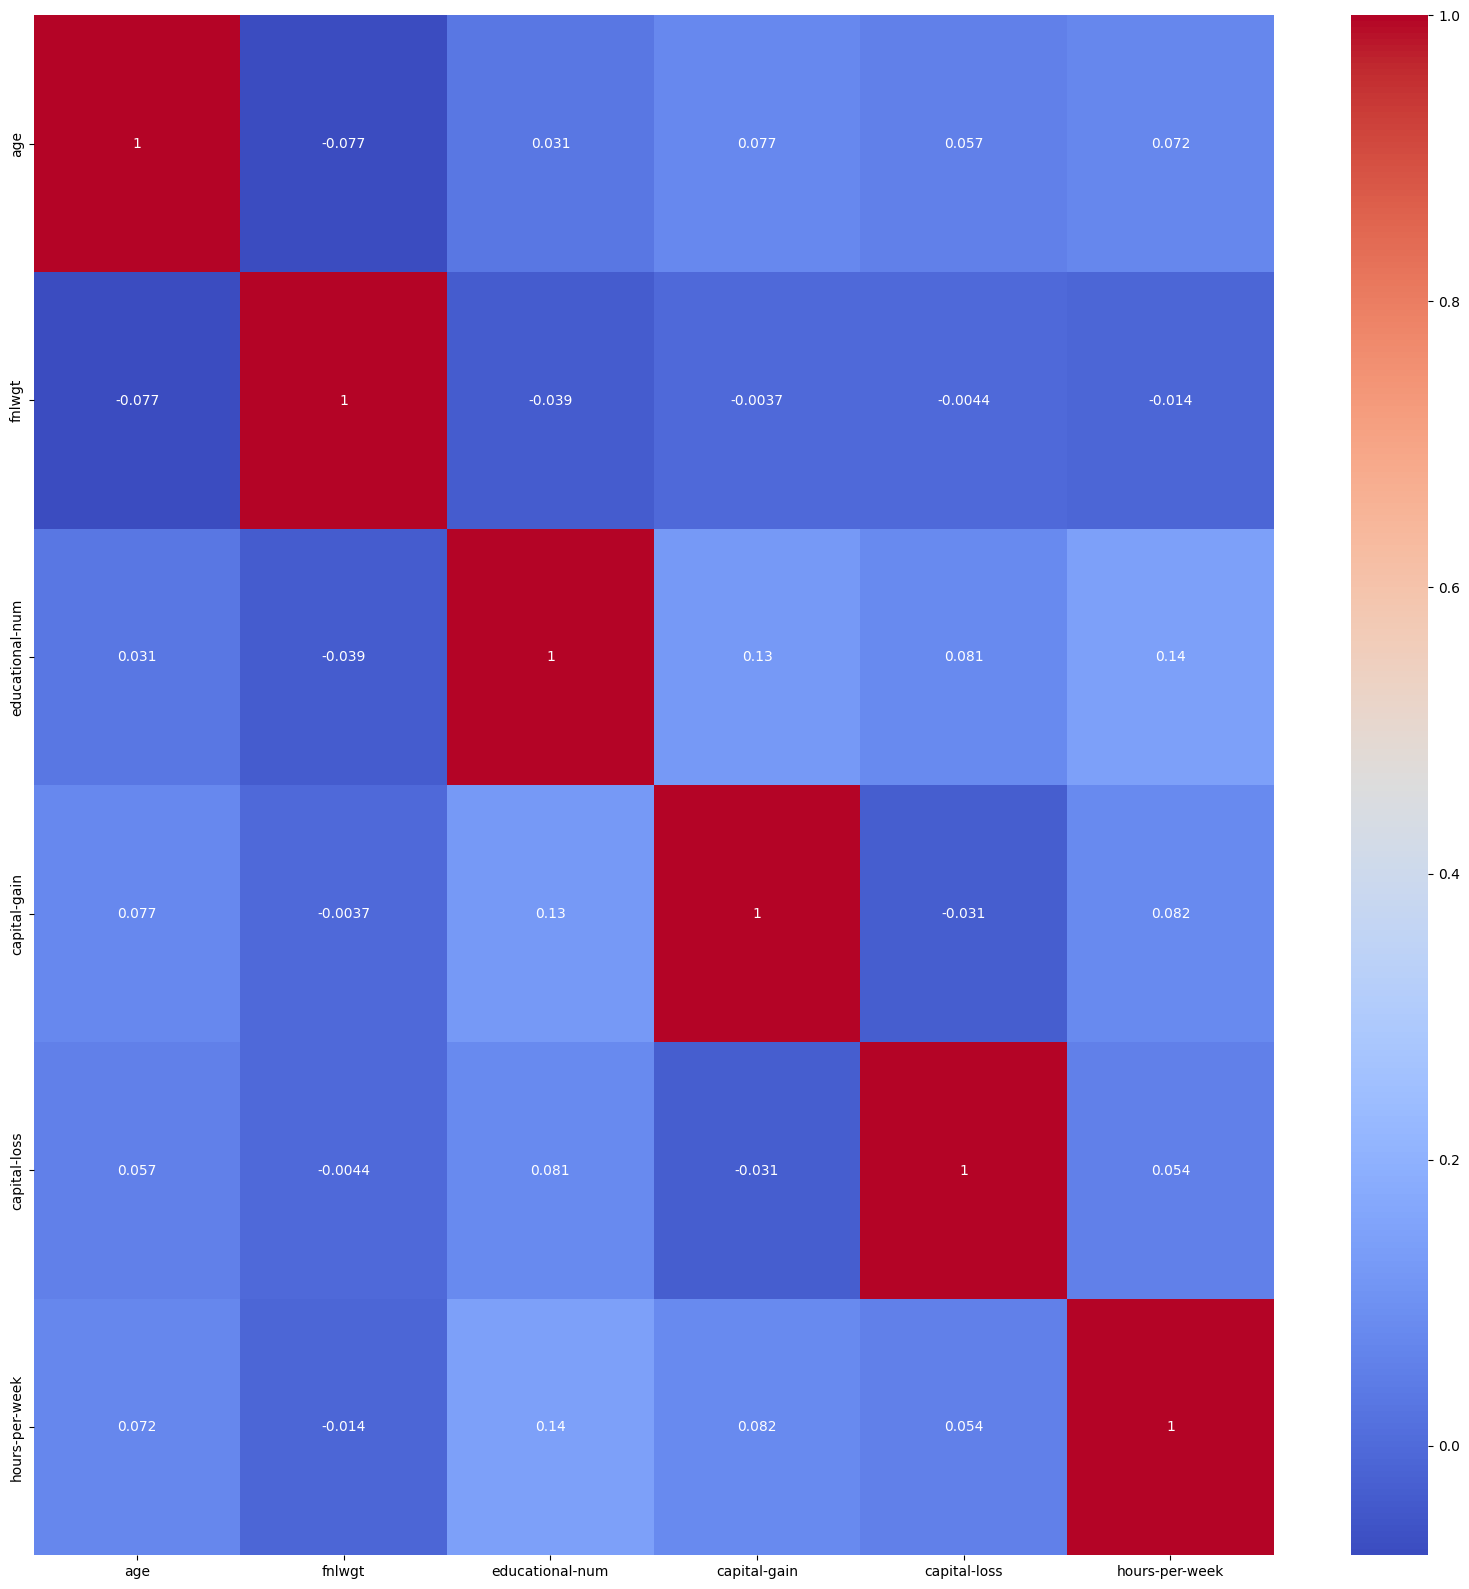

In [25]:
# Create a fig, ax with a figsize argument
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, cmap = 'coolwarm', annot = True, ax=ax);



- Very low magnitudes, so cannot identify any relationships between variables in our dataset.

In [26]:
# Representing the mean age based on income
mean_incage = df.groupby('income')['age'].mean()
mean_incage



income
<=50K    36.872184
>50K     44.275178
Name: age, dtype: float64

In [27]:
df.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


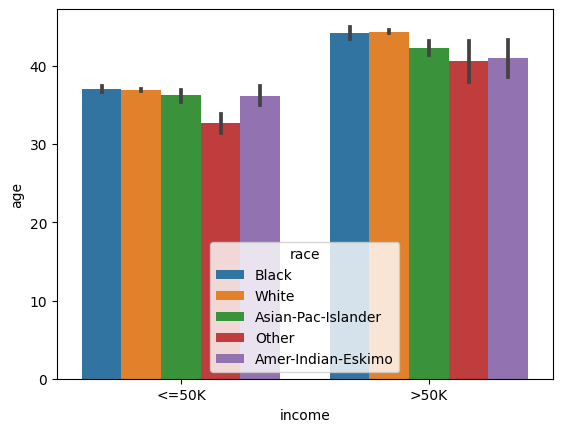

In [28]:
# Barplot of Income vs Age
ax = sns.barplot(data=df, x='income', y='age', hue='race')

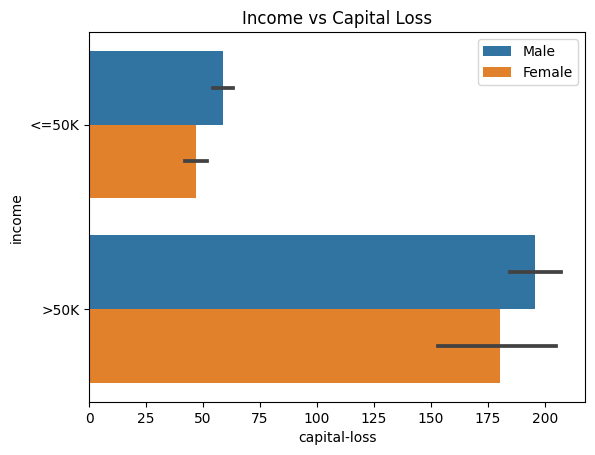

In [29]:
ax = sns.barplot(data = df, x = 'capital-loss', y = 'income', hue = 'gender')

## Set the Title
ax.set_title('Income vs Capital Loss');



## Set the Legend location
ax.legend(loc = 'best');

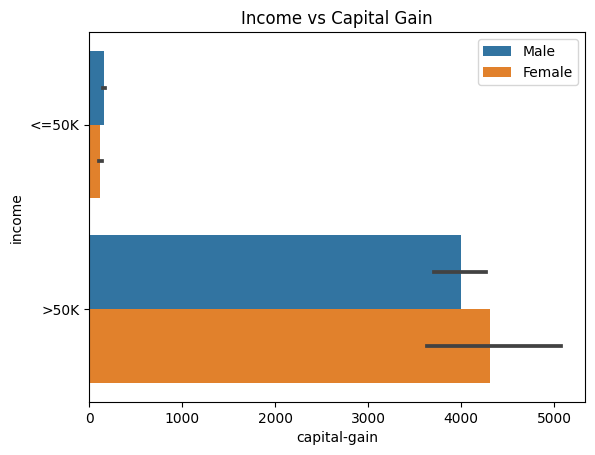

In [30]:
ax = sns.barplot(data = df, x = 'capital-gain', y = 'income', hue = 'gender')

## Set the Title
ax.set_title('Income vs Capital Gain');



## Set the Legend location
ax.legend(loc = 'best');

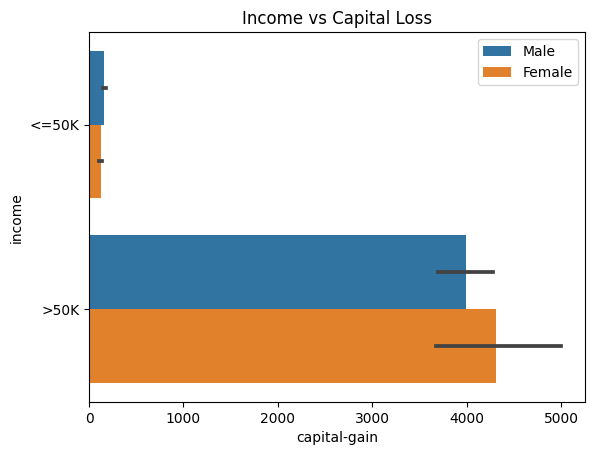

In [31]:
ax = sns.barplot(data = df, x = 'capital-gain', y = 'income', hue = 'gender')

## Set the Title
ax.set_title('Income vs Capital Loss');



## Set the Legend location
ax.legend(loc = 'best');

### Additional Visualizations

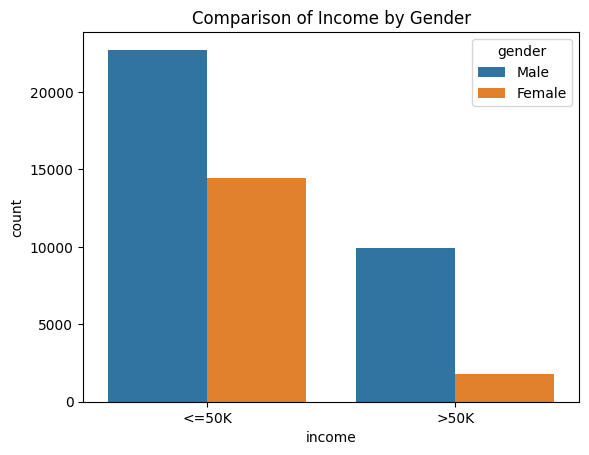

In [32]:
# Multivariate countplot with a hue argument
ax = sns.countplot(data=df, x='income', hue='gender')
ax.set_title('Comparison of Income by Gender');





- Greater number of people make less than 50K.  The male to female discrepancy is pretty glaring as well.  Large portion of that is that the numbers aren't balanced from the start.  May be better served if you polled the same number of Male/Female.  

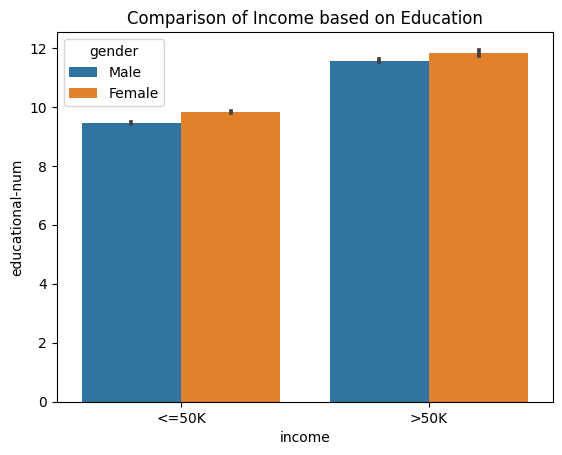

In [33]:
# Barplot of Income vs Education
ax = sns.barplot(data=df, x='income', y='educational-num', hue='gender')
ax.set_title('Comparison of Income based on Education');









- Education definitely plays a key factor in the income, which based on our society, is to be expected.  

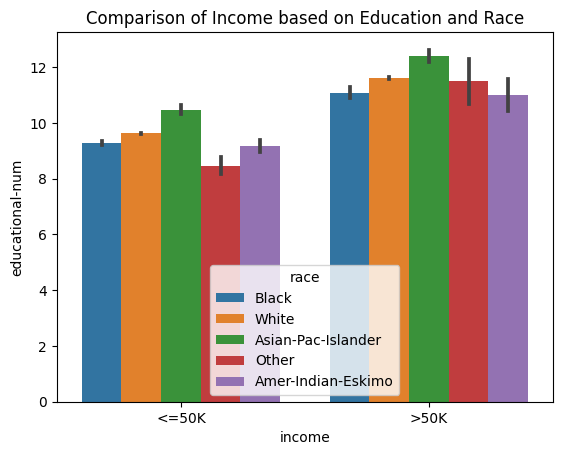

In [34]:
# Barplot of Income vs Education
ax = sns.barplot(data=df, x='income', y='educational-num', hue='race')
ax.set_title('Comparison of Income based on Education and Race');






- We have already established that education plays a role, but this shows the distribution between races...with the Asian Pac Islander group leading the pack.  

## Will use Log Regression (Adult Income)


In [35]:
# Drop irrelevant and high cardinality features
cols_drop = ['fnlwgt']
# Create features matrix and target vector
X = df.drop(columns = [*cols_drop, 'income'])
y = df['income']
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [36]:
# Checking how many healthy patients vs. PD
y_train.value_counts(normalize=True)



<=50K    0.758947
>50K     0.241053
Name: income, dtype: float64

In [37]:
# Save list of numeric columns
num_cols = X_train.select_dtypes('number').columns
# Constructing numeric preprocesssing objects
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
num_pipe = make_pipeline(num_imputer, scaler)
num_tuple = ('num',num_pipe, num_cols)
num_tuple

('num',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
        'hours-per-week'],
       dtype='object'))

In [38]:
# Saving list of categorical columns
cat_cols = X_train.select_dtypes('object').columns
# Constructing categorical preprocessing objects
cat_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_pipe = make_pipeline(cat_imputer,ohe_encoder)
cat_tuple = ('cat',cat_pipe, cat_cols)
cat_tuple

('cat',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='MISSING', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['workclass', 'education', 'marital-status', 'occupation',
        'relationship', 'race', 'gender', 'native-country'],
       dtype='object'))

In [39]:
# Define a column transformer
preprocessor  = ColumnTransformer([num_tuple, cat_tuple],
                                  verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [40]:
# Make an instance of the model with default parameters
logreg = LogisticRegression(max_iter=500, random_state=42)

# Put preprocessor and model in a pipeline
logreg_pipe = make_pipeline(preprocessor, logreg)
# Training the model on the data, storing the information learned from the data
# Model is learning the relationship between X and y
logreg_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     27801
        >50K       0.73      0.60      0.66      8830

    accuracy                           0.85     36631
   macro avg       0.81      0.76      0.78     36631
weighted avg       0.84      0.85      0.85     36631



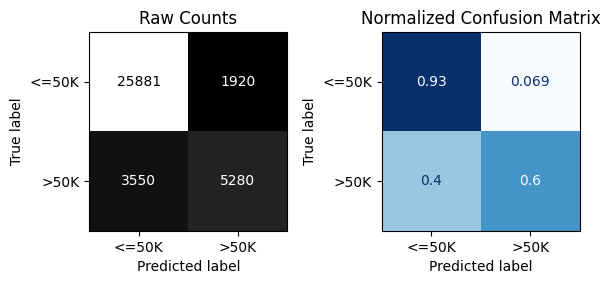


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      9354
        >50K       0.74      0.61      0.67      2857

    accuracy                           0.86     12211
   macro avg       0.81      0.77      0.79     12211
weighted avg       0.85      0.86      0.85     12211



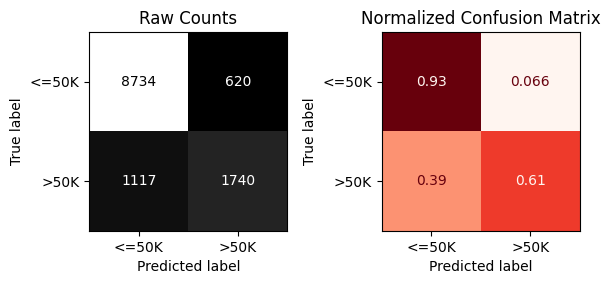

In [41]:
# Evaluate the default model
evaluate_classification(logreg_pipe, X_train, y_train, X_test, y_test)



# Tuning L1 Regularization

In [42]:
# Create the logreg pipe with L1 regularization
logreg_pipe = make_pipeline(scaler, LogisticRegression(penalty='l1',
                                                       random_state=42,
                                                       max_iter=500))
logreg_pipe.get_params()


{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression',
   LogisticRegression(max_iter=500, penalty='l1', random_state=42))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(max_iter=500, penalty='l1', random_state=42),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 500,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l1',
 'logisticregression__random_state': 42,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [43]:
# Make an instance of the model with default parameters
logreg = LogisticRegression(max_iter=500, random_state=42)

# Put scaler and model in a pipeline
logreg_pipe = make_pipeline(preprocessor, logreg)

# Training the model on the data, storing the information learned from the data
# Model is learning the relationship between X and y
logreg_pipe.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=42))])

In [44]:
# Remaking the model with solver='liblinear'
logreg_pipe = make_pipeline(preprocessor, LogisticRegression(solver='liblinear',
                                                       max_iter=500,
                                                       penalty='l1',
                                                       random_state=42))
# Define the param grid
params={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
# Create the GridSearchCV object with required args
gs = GridSearchCV(logreg_pipe, params, verbose=True, n_jobs=-1,
                  return_train_score=True,scoring='recall_macro')
# Fit the gridsearch and display best params
gs.fit(X_train, y_train)
print(f'Best Params: {gs.best_params_}')



Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Params: {'logisticregression__C': 10000}


In [45]:
# Making a dataframe with cv_results_
cv_results = pd.DataFrame(gs.cv_results_)
# Save the train/test scores + value for C
scores = cv_results[['param_logisticregression__C','mean_train_score','mean_test_score']]
scores = scores.set_index('param_logisticregression__C')
scores


,mean_train_score,mean_test_score
param_logisticregression__C,,
0.0001,0.500000,0.500000
0.0010,0.644760,0.643741
0.0100,0.744692,0.744450
0.1000,0.760938,0.759788
1.0000,0.764525,0.763359
10.0000,0.765066,0.763483
100.0000,0.765133,0.763522
1000.0000,0.765148,0.763522
10000.0000,0.765148,0.763540


param_logisticregression__C
0.0001        0.500000
0.0010        0.643741
0.0100        0.744450
0.1000        0.759788
1.0000        0.763359
10.0000       0.763483
100.0000      0.763522
1000.0000     0.763522
10000.0000    0.763540
Name: mean_test_score, dtype: float64


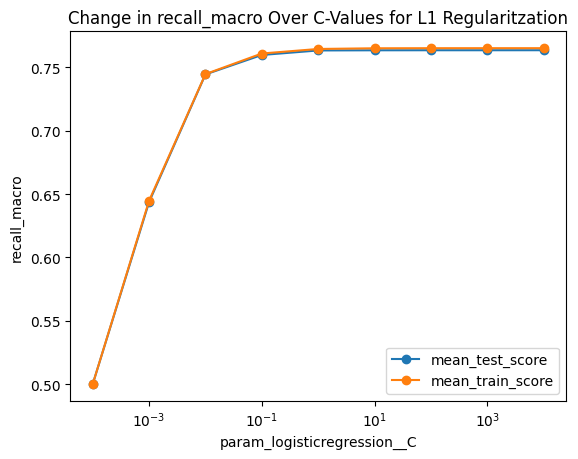

In [46]:
## Plot the training vs test scores vs. C
ax = scores.plot(y=['mean_test_score','mean_train_score'],
            style='o-',logx=True)
ax.set(ylabel=gs.scoring,
       title=f'Change in {gs.scoring} Over C-Values for L1 Regularitzation')
print(scores['mean_test_score'])


# What is the best

In [47]:
# Params compatible with penality='elasticnet'
elasticnet_params = {'logisticregression__solver' : ['saga'],
               'logisticregression__penalty' : ['elasticnet'],
                'logisticregression__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4,
                                                 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
# Params compatible with penality='l2'
l2_params = {'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                            'newton-cholesky', 'sag', 'saga'],
                  'logisticregression__penalty' : ['l2'],
                  'logisticregression__C': [0.0001, 0.001, 0.01, 0.1,
                                            1, 10, 100, 1000] }
# Params compatible with penality='l1'
l1_params = {'logisticregression__solver' : ['liblinear', 'saga'],
               'logisticregression__penalty' : ['l1'],
                'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                          10, 100, 1000]}
# Params with no penality
none_params = {'logisticregression__solver' : ['lbfgs', 'newton-cg',
                                               'newton-cholesky', 'sag', 'saga'],
               'logisticregression__penalty' : [None]}
# Now make a list of the param dictionaries
param_grid = [l2_params, l1_params, elasticnet_params, none_params]



In [48]:
## Warning: this gridsearch may take 5-10 minutes to run!!
# Instantiate gridsearch
gs = GridSearchCV(logreg_pipe, param_grid, verbose = 5, n_jobs = -1,
                  scoring='recall_macro')
# Fit the gs on the training data only
gs.fit(X_train, y_train)
gs.best_params_


Fitting 5 folds for each of 80 candidates, totalling 400 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'logisticregression__l1_ratio': 0.1,
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__solver': 'saga'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90     27801
        >50K       0.73      0.60      0.66      8830

    accuracy                           0.85     36631
   macro avg       0.81      0.76      0.78     36631
weighted avg       0.84      0.85      0.85     36631



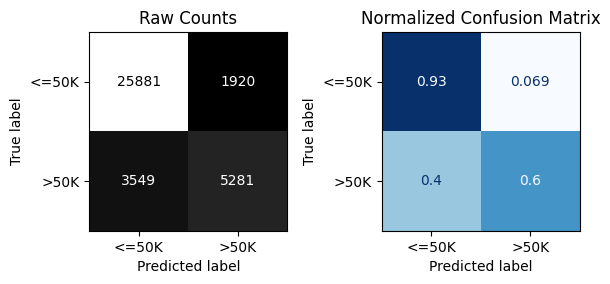


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      9354
        >50K       0.74      0.61      0.67      2857

    accuracy                           0.86     12211
   macro avg       0.81      0.77      0.79     12211
weighted avg       0.85      0.86      0.85     12211



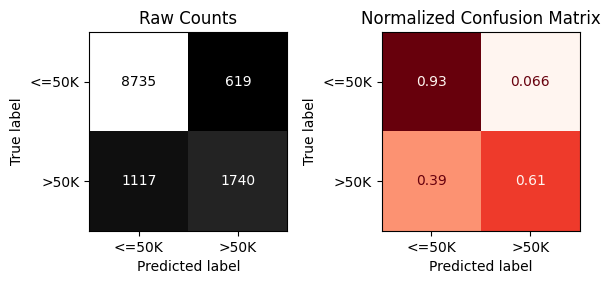

In [49]:
# Evalaute the best model
best_logreg = gs.best_estimator_
evaluate_classification(best_logreg, X_train, y_train, X_test, y_test)


- Our best model, with a recall macro avg of .77, found our best hyperparameter settings for our logistic regression model would be solver='saga', penalty='elasticnet,' and l1_ratio=0.1. An l1 ratio of .1 means that the model used a combination of l1 and l2 regularization.

## Feature Techniques (Adult Income)

In [48]:
df['Captial +/-'] = df['capital-gain'] - df['capital-loss']
df.drop(columns=['capital-gain','capital-loss'], inplace= True)
df.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income,Captial +/-
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,<=50K,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,>50K,0
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K,7688
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,30,United-States,<=50K,0


In [49]:
df['age'] = df['age'].apply(lambda x: 'elderly' if x > 30 else 'young')
df.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income,Captial +/-
0,young,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K,0
1,elderly,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,<=50K,0
2,young,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,>50K,0
3,elderly,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K,7688
4,young,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,30,United-States,<=50K,0
